In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-tumor-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5493518%2F9102502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240812%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240812T011231Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D850e25dcf1493e113d086d84c99aea9727bfc6e1e15c33e4cd2446c39b8b9ec4a9c8b54002dacdbca4fd9b2364c6e0a942ecd800ebe6de56e10fb74efc12547c8823e0835047f9f9c84153c399163376f1a1b91f2b9010342ba6dd5b297bd08a6e36f7cee2284b53ae68e8c6290c679028ab5f2f8e13ecd297f61e2f4bbb142e9817c3392971631b9a2607e012640586f322a8df5feac9ea1c0a75974b0806f8cd581b1d9051e846b7da56c3d9c88fa9f6bb0b4a215ee70aba99849bc7569e29486b3170235c145a8d0f6ecfcf597a9e9693e78dbb67c50c58189909f210d39b71f74b750b0527b21999f0e37d6d3c19889587d0a18ca9a5b771ed5d6bd5badc'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 7351 bytes downloaded
Downloaded and uncompressed: brain-tumor-dataset
Data source import complete.


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/brain-tumor-dataset/brain_tumor_dataset.csv


In [3]:
# Load the data
data = pd.read_csv('/kaggle/input/brain-tumor-dataset/brain_tumor_dataset.csv')
data.head()

,Tumor Type,Location,Size (cm),Grade,Patient Age,Gender
0,Oligodendroglioma,Occipital Lobe,9.23,I,48,Female
1,Ependymoma,Occipital Lobe,0.87,II,47,Male
2,Meningioma,Occipital Lobe,2.33,II,12,Female
3,Ependymoma,Occipital Lobe,1.45,III,38,Female
4,Ependymoma,Brainstem,6.45,I,35,Female


# Fields and Data Types 🏥:
The dataset includes the following attributes:

- Patient ID: Unique identifier for each patient.
- Age: The age of the patient at the time of diagnosis.
- Gender: The gender of the patient (Male/Female).
- Tumor Type: Classification of the tumor type (e.g., Meningioma, Glioma, Pituitary Tumor).
- Tumor Location: The location of the tumor within the brain.
- MRI Images: Scans from different MRI modalities, such as T1-weighted, T2-weighted, FLAIR, etc.
- Clinical Notes: Any relevant clinical observations or symptoms recorded by healthcare professionals.
- Treatment Plan: Information on the treatment approach, including surgery, radiotherapy, chemotherapy, or a combination.

In [4]:
# Display information about the dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tumor Type   1000 non-null   object 
 1   Location     1000 non-null   object 
 2   Size (cm)    1000 non-null   float64
 3   Grade        1000 non-null   object 
 4   Patient Age  1000 non-null   int64  
 5   Gender       1000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 47.0+ KB
None


In [5]:
# Descriptive statistics
data.describe()

,Size (cm),Patient Age
count,1000.000000,1000.000000
mean,5.221500,43.519000
std,2.827318,25.005818
min,0.510000,1.000000
25%,2.760000,22.000000
50%,5.265000,43.000000
75%,7.692500,65.000000
max,10.000000,89.000000


In [6]:
# Display column names
data.columns

Index(['Tumor Type', 'Location', 'Size (cm)', 'Grade', 'Patient Age',
       'Gender'],
      dtype='object')

In [7]:
# Renames the dataset and removes the space
data=data.rename(columns={
    "Tumor Type":"Tumor_Type",
    "Size (cm)": "Size",
    "Patient Age": "Age",
    })
data.head()

,Tumor_Type,Location,Size,Grade,Age,Gender
0,Oligodendroglioma,Occipital Lobe,9.23,I,48,Female
1,Ependymoma,Occipital Lobe,0.87,II,47,Male
2,Meningioma,Occipital Lobe,2.33,II,12,Female
3,Ependymoma,Occipital Lobe,1.45,III,38,Female
4,Ependymoma,Brainstem,6.45,I,35,Female


# Handling missing data

In [8]:
# Verify the data
print(data.isnull().sum())

Tumor_Type    0
Location      0
Size          0
Grade         0
Age           0
Gender        0
dtype: int64


# EDA (Exploratory Data Analysis)

<ipython-input-9-fc643587cd0a>:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=ax1,data=data,x='Tumor_Type',palette=color_palette)
<ipython-input-9-fc643587cd0a>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
<ipython-input-9-fc643587cd0a>:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=ax2,data=data,x='Location',palette=color_palette)
<ipython-input-9-fc643587cd0a>:45: UserWarning: 
The palette list has fewer values (5) than needed (6) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(ax=ax2,data=data,x='Location',palette=color_palette)
<ipython-inpu

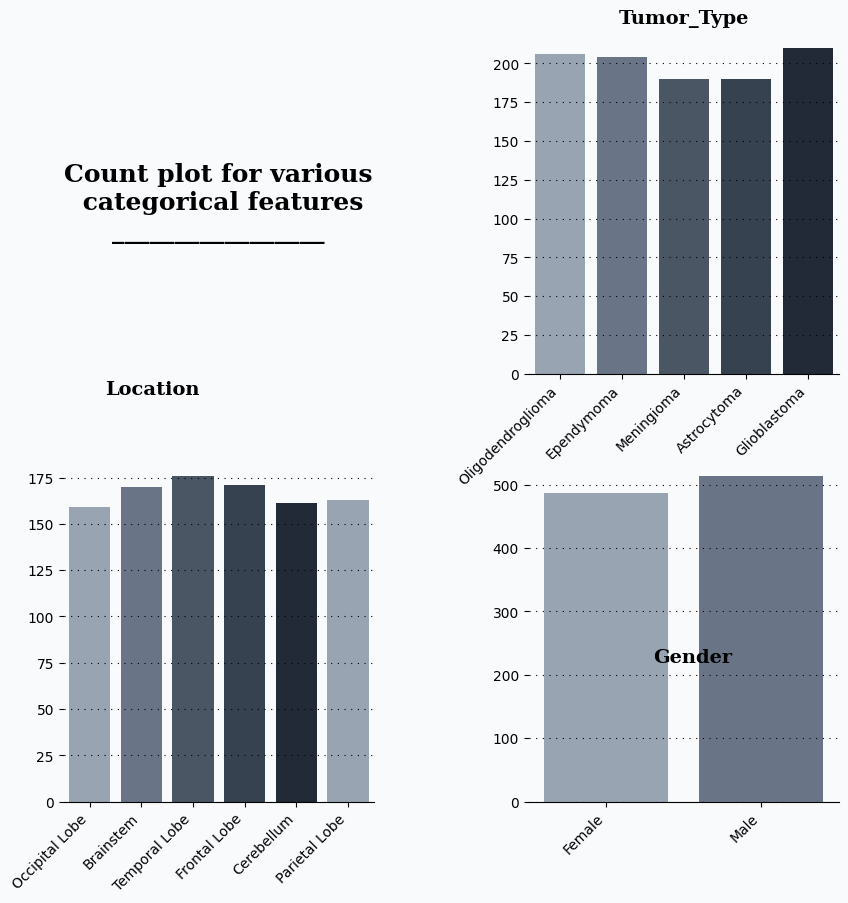

In [9]:
# Count plot of categorical features
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(2,2)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,0])
ax3 = fig.add_subplot(gs[1,1])

background_color = "#f8fafc"
color_palette = ["#94a3b8","#64748b","#475569","#334155","#1e293b"]
fig.patch.set_facecolor(background_color)
ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color)
ax2.set_facecolor(background_color)
ax3.set_facecolor(background_color)

# Title of the plot
ax0.spines["bottom"].set_visible(False)
ax0.spines["left"].set_visible(False)
ax0.spines["top"].set_visible(False)
ax0.spines["right"].set_visible(False)
ax0.tick_params(left=False, bottom=False)
ax0.set_xticklabels([])
ax0.set_yticklabels([])
ax0.text(0.5,0.5,
         'Count plot for various\n categorical features\n_________________',
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=18, fontweight='bold',
         fontfamily='serif',
         color="#000000")

# Tumor Type count
ax1.set_title("Tumor_Type", loc='center', fontsize=14, fontweight='bold', fontfamily="serif", color="#000000")
ax1.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax1,data=data,x='Tumor_Type',palette=color_palette)
ax1.set_xlabel("")
ax1.set_ylabel("")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

# Location count
ax2.text(0.3, 220, 'Location', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax2.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax2,data=data,x='Location',palette=color_palette)
ax2.set_xlabel("")
ax2.set_ylabel("")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Gender count
ax3.text(0.3, 220, 'Gender', fontsize=14, fontweight='bold', fontfamily='serif', color="#000000")
ax3.grid(color='#000000', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
sns.countplot(ax=ax3, data=data, x='Gender', palette=color_palette)
ax3.set_xlabel("")
ax3.set_ylabel("")
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')

for s in ["top","right","left"]:
    ax1.spines[s].set_visible(False)
    ax2.spines[s].set_visible(False)
    ax3.spines[s].set_visible(False)


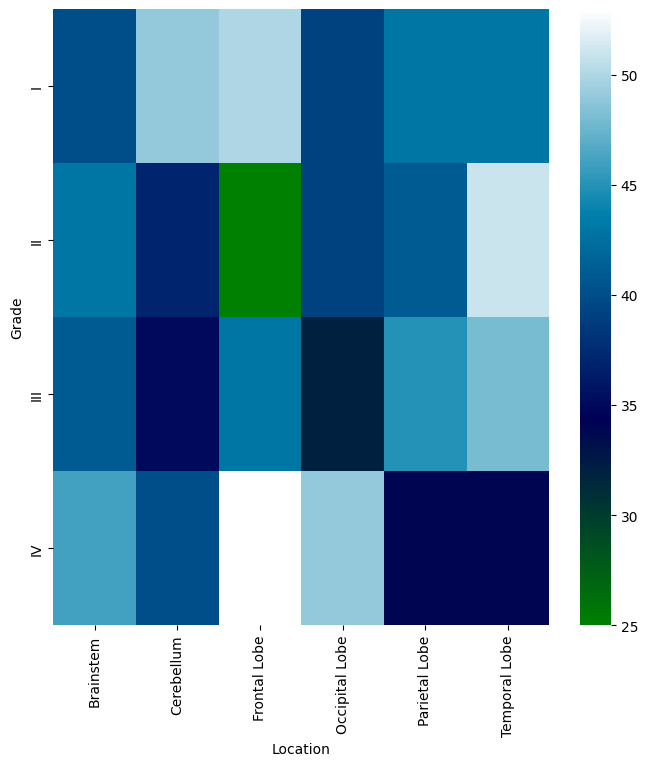

In [10]:
# Location vs Grade
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Grade'].value_counts()
    for x_label, grp in data.groupby('Location')
})
sns.heatmap(df_2dhist, cmap='ocean')
plt.xlabel('Location')
_ = plt.ylabel('Grade')

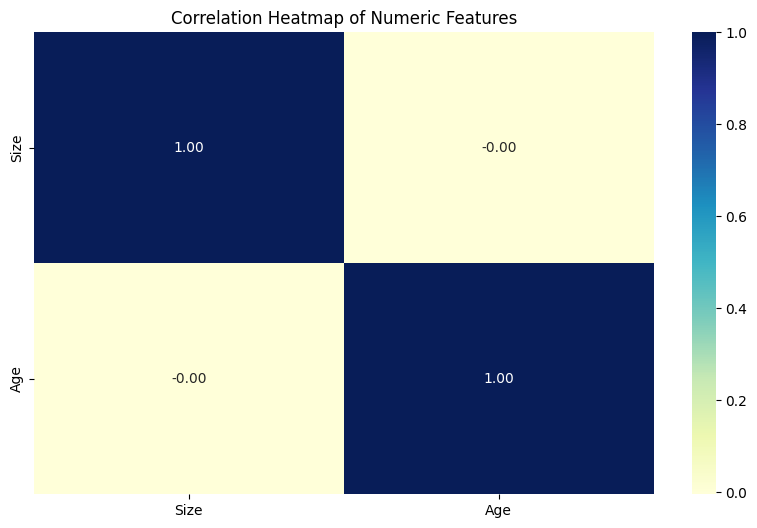

In [11]:
# Correlation heatmap of numeric features
numeric_df = data.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

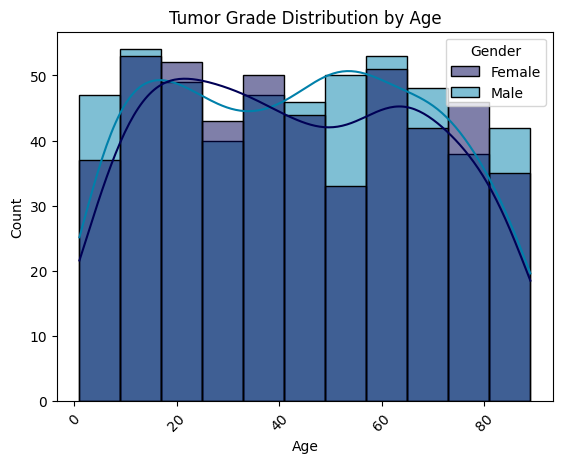

In [12]:
# Tumor Grade Distribution by Age
plt.xticks(rotation=45)
sns.histplot(data=data, x='Age', hue="Gender",palette="ocean", kde=True)
plt.title('Tumor Grade Distribution by Age')
plt.show()

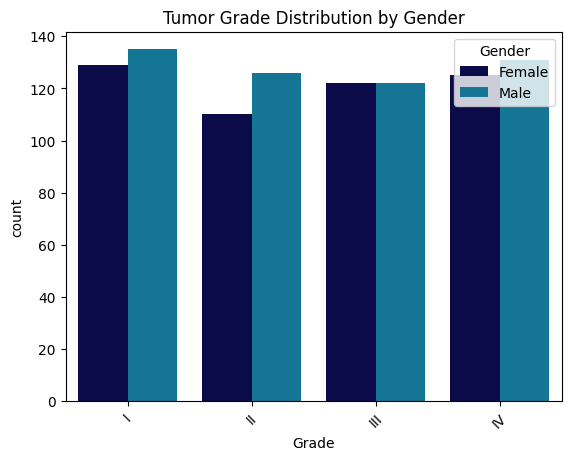

In [13]:
# Tumor Grade Distribution by Gender
plt.xticks(rotation=45)
sns.countplot(data=data,x='Grade', hue='Gender', palette="ocean")
plt.title('Tumor Grade Distribution by Gender')
plt.show()

Text(0.5, 1.0, 'Tumor Size Distribution by Type and Grade')

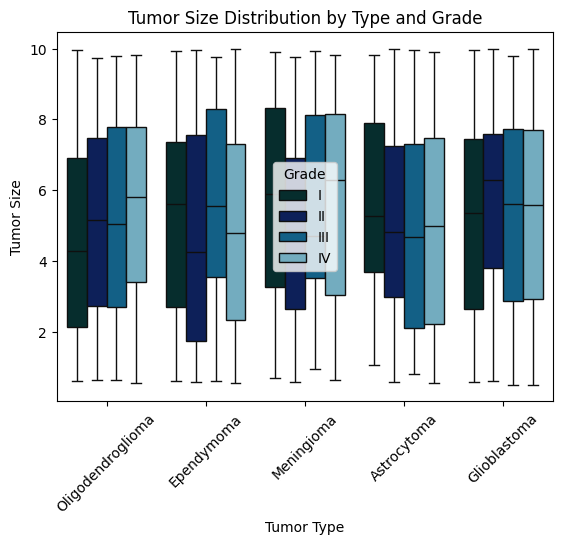

In [14]:
# Tumor Size Distribution by Type and Grade
plt.xticks(rotation=45)
sns.boxplot(x='Tumor_Type', y='Size', hue='Grade', data=data, palette="ocean")
plt.xlabel('Tumor Type')
plt.ylabel('Tumor Size')
plt.title('Tumor Size Distribution by Type and Grade')

<ipython-input-15-9c0d4907a67d>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Tumor_Type', y='Age', data=data, palette="ocean")


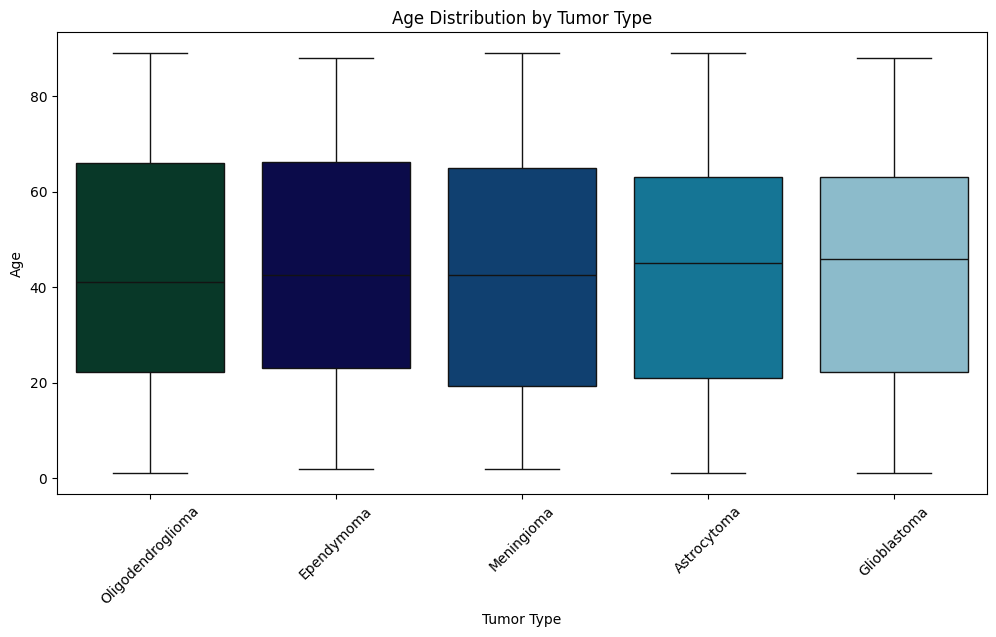

In [15]:
# Age Distribution by Tumor Type
plt.figure(figsize=(12, 6))
sns.boxplot(x='Tumor_Type', y='Age', data=data, palette="ocean")
plt.title('Age Distribution by Tumor Type')
plt.xlabel('Tumor Type')
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()

<ipython-input-16-8760e5773c8c>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Location', y='Size', data=data, palette="ocean")


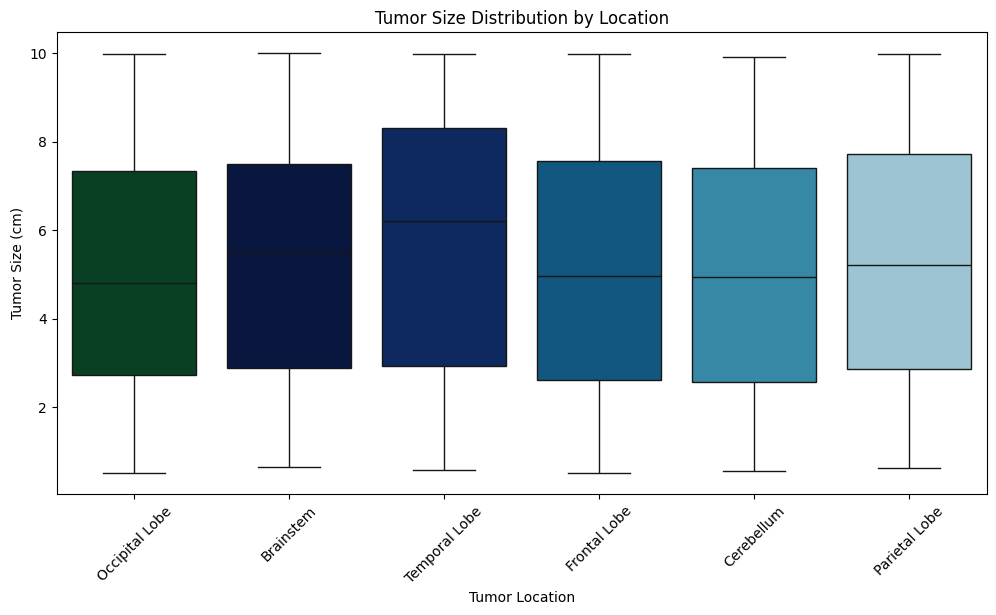

In [16]:
# Tumor Size Distribution by Location
plt.figure(figsize=(12, 6))
sns.boxplot(x='Location', y='Size', data=data, palette="ocean")
plt.title('Tumor Size Distribution by Location')
plt.xlabel('Tumor Location')
plt.ylabel('Tumor Size (cm)')
plt.xticks(rotation=45)
plt.show()

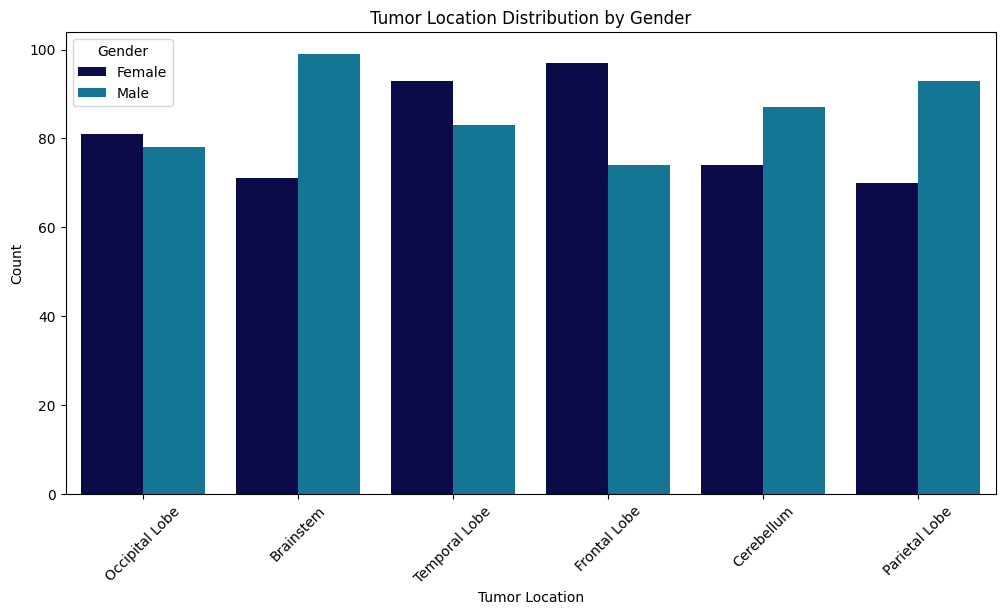

In [17]:
# Tumor Location Distribution by Gender
plt.figure(figsize=(12, 6))
sns.countplot(data=data, x='Location', hue='Gender', palette="ocean")
plt.title('Tumor Location Distribution by Gender')
plt.xlabel('Tumor Location')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


# Detection and Treatment of Outliers

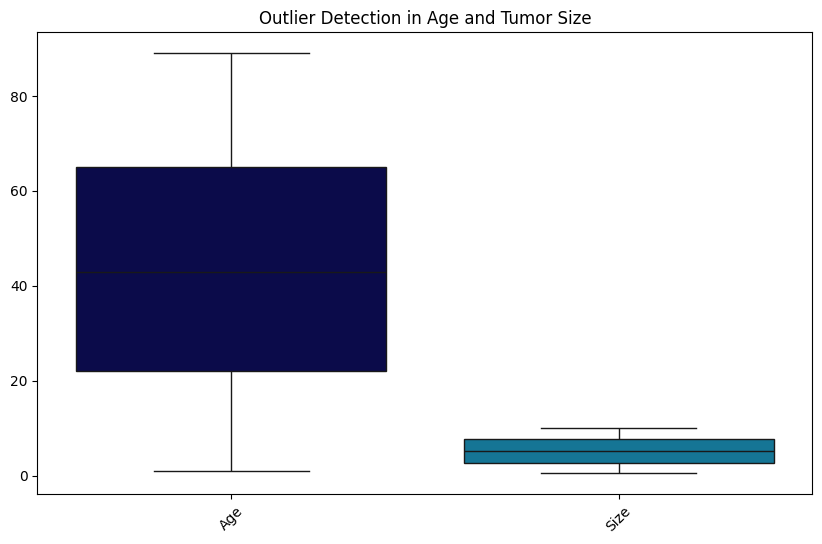

Outliers in Tumor Size:
Empty DataFrame
Columns: [Tumor_Type, Location, Size, Grade, Age, Gender]
Index: []


In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['Age', 'Size']], palette="ocean")
plt.xticks(rotation=45)
plt.title('Outlier Detection in Age and Tumor Size')
plt.show()

# Identifying outliers in 'Size'
Q1 = data['Size'].quantile(0.25)
Q3 = data['Size'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = data[(data['Size'] < lower_bound) | (data['Size'] > upper_bound)]
print(f'Outliers in Tumor Size:\n{outliers}')

# Principal Component Analysis (PCA)

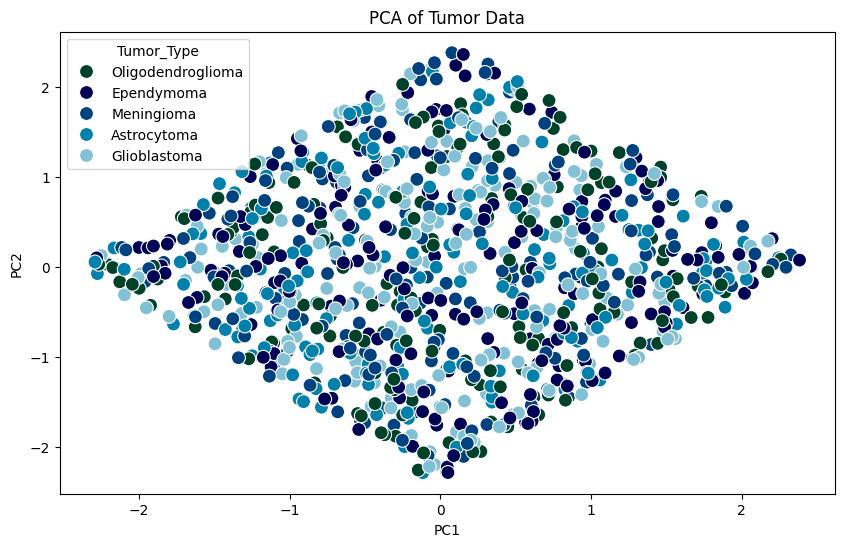

In [19]:
# Selecting numeric columns for PCA
numeric_columns = ['Age', 'Size']
X = data[numeric_columns].copy()

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Adding the Tumor_Type for visualization
pca_df['Tumor_Type'] = data['Tumor_Type']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Tumor_Type', data=pca_df, palette="ocean", s=100)
plt.title('PCA of Tumor Data')
plt.show()

# Grouping Age into categories

In [20]:
# data_copy = data.copy()
# data_copy.head()

In [21]:
# Grouping Age into categories
bins = [0, 18, 40, 60, 100]
labels = ['Child', 'Young Adult', 'Adult', 'Senior']
data['Age_Group'] = pd.cut(data['Age'], bins=bins, labels=labels)
data.head()

,Tumor_Type,Location,Size,Grade,Age,Gender,Age_Group
0,Oligodendroglioma,Occipital Lobe,9.23,I,48,Female,Adult
1,Ependymoma,Occipital Lobe,0.87,II,47,Male,Adult
2,Meningioma,Occipital Lobe,2.33,II,12,Female,Child
3,Ependymoma,Occipital Lobe,1.45,III,38,Female,Young Adult
4,Ependymoma,Brainstem,6.45,I,35,Female,Young Adult


# Creating a binary feature for critical location

In [22]:
# Creating a binary feature for critical location
critical_locations = ['Brainstem', 'Cerebellum']
data['Critical_Location'] = data['Location'].apply(lambda x: 1 if x in critical_locations else 0)
data.head()

,Tumor_Type,Location,Size,Grade,Age,Gender,Age_Group,Critical_Location
0,Oligodendroglioma,Occipital Lobe,9.23,I,48,Female,Adult,0
1,Ependymoma,Occipital Lobe,0.87,II,47,Male,Adult,0
2,Meningioma,Occipital Lobe,2.33,II,12,Female,Child,0
3,Ependymoma,Occipital Lobe,1.45,III,38,Female,Young Adult,0
4,Ependymoma,Brainstem,6.45,I,35,Female,Young Adult,1


# Automated Report

=== Statistical Summary of Numerical Variables ===
              Size          Age  Critical_Location
count  1000.000000  1000.000000        1000.000000
mean      5.221500    43.519000           0.331000
std       2.827318    25.005818           0.470809
min       0.510000     1.000000           0.000000
25%       2.760000    22.000000           0.000000
50%       5.265000    43.000000           0.000000
75%       7.692500    65.000000           1.000000
max      10.000000    89.000000           1.000000


===== Distribution of Categorical Variables ======
Distribution of Grade:
Grade
I      264
IV     256
III    244
II     236
Name: count, dtype: int64


Distribution of Age_Group:
Age_Group
Senior         300
Young Adult    254
Adult          228
Child          218
Name: count, dtype: int64




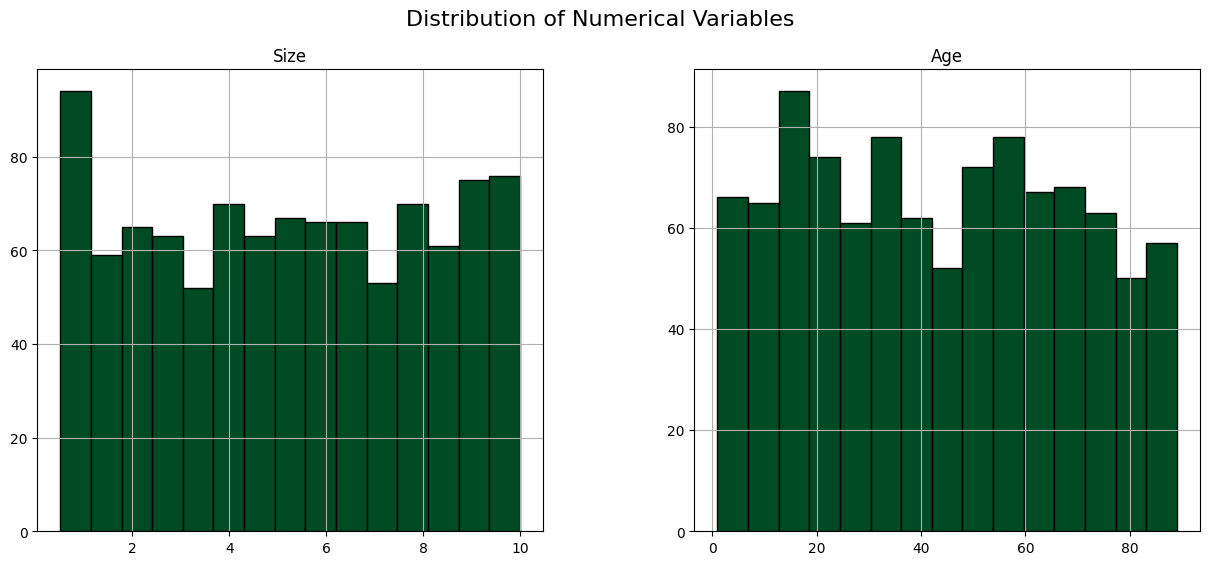

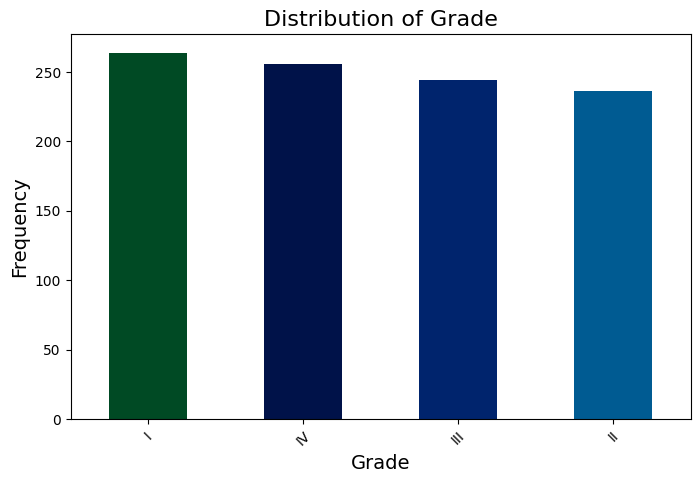

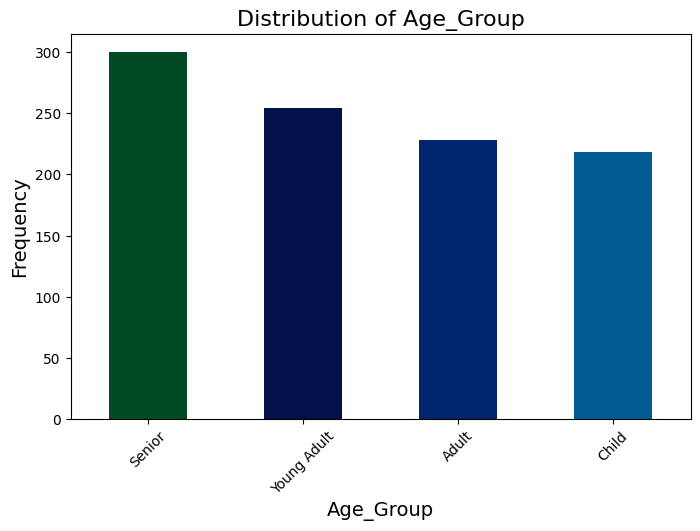

============== Correlation Analysis ==============
                       Size       Age  Critical_Location
Size               1.000000 -0.004661          -0.021512
Age               -0.004661  1.000000          -0.026425
Critical_Location -0.021512 -0.026425           1.000000


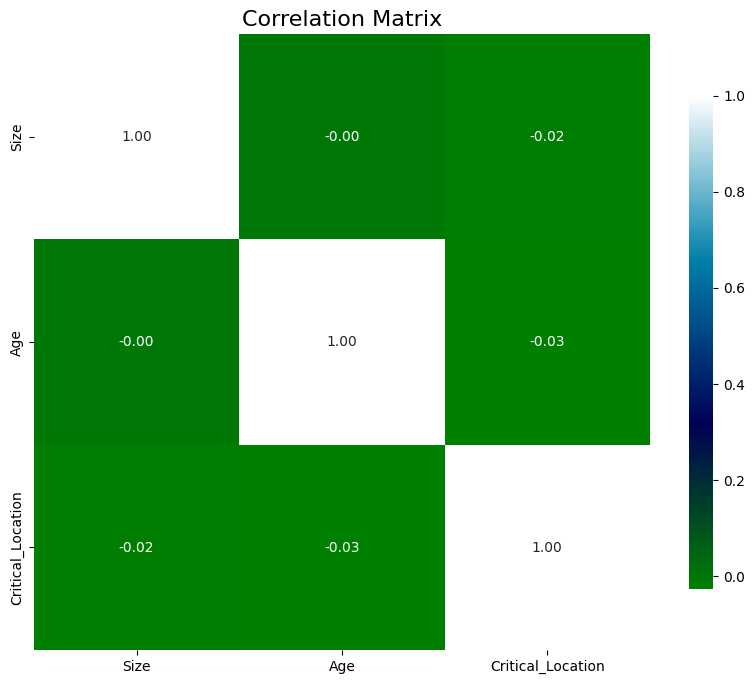

In [23]:
# Set the color palette
sns.set_palette("ocean")

# Load the data
# data = pd.read_csv('path_to_your_data.csv')

# Generate a statistical summary of numerical variables
def generate_statistical_summary(data):
    print(" Statistical Summary of Numerical Variables ".center(50,"="))
    print(data.describe())
    print("\n")

# Distribution of categorical variables
def categorical_distribution(data, categorical_cols):
    print(" Distribution of Categorical Variables ".center(50,"="))
    for col in categorical_cols:
        print(f"Distribution of {col}:")
        print(data[col].value_counts())
        print("\n")

# Distribution graphs for numerical variables
def plot_numerical_distributions(data, numerical_cols):
    data[numerical_cols].hist(bins=15, figsize=(15, 6), edgecolor='black')
    plt.suptitle('Distribution of Numerical Variables', fontsize=16)
    plt.show()

# Bar graphs for categorical variables
def plot_categorical_bars(data, categorical_cols):
    for col in categorical_cols:
        plt.figure(figsize=(8, 5))
        data[col].value_counts().plot(kind='bar', color=sns.color_palette("ocean"))
        plt.title(f'Distribution of {col}', fontsize=16)
        plt.xlabel(col, fontsize=14)
        plt.ylabel('Frequency', fontsize=14)
        plt.xticks(rotation=45)
        plt.show()

# Correlation analysis between numerical variables
def correlation_analysis(numeric_df):
    print(" Correlation Analysis ".center(50,"="))
    corr = numeric_df.corr()
    print(corr)
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="ocean", square=True, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix', fontsize=16)
    plt.show()

# Execute functions
generate_statistical_summary(data)
categorical_distribution(data, ['Grade', 'Age_Group'])
plot_numerical_distributions(data, ['Size', 'Age'])
plot_categorical_bars(data, ['Grade', 'Age_Group'])
correlation_analysis(data.select_dtypes(include='number'))